In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset


In [2]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)

In [3]:
path.ls()

(#50) [Path('/Users/parhamzam/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/07.obj'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/13.obj'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/03'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/04'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/12.obj'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/06.obj'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/10.obj'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/04.obj'),Path('/Users/parhamzam/.fastai/data/biwi_head_pose/05')...]

In [4]:
img_files = get_image_files(path)
def img2pose(x) : return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/Users/parhamzam/.fastai/data/biwi_head_pose/03/frame_00393_pose.txt')

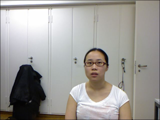

In [5]:
im = PILImage.create(img_files[0])
im.shape
im.to_thumb(160)

<Axes: >

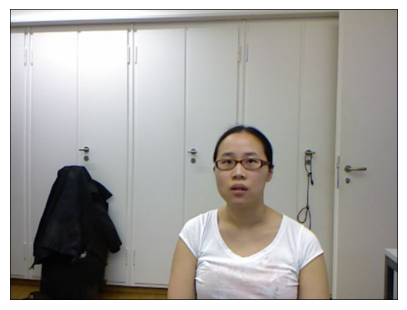

In [6]:
im.show()

In [7]:
t = img2pose(img_files[0])

In [11]:
t.read_text()

'0.986035 -0.0415048 0.161283 \n0.0173199 0.988752 0.148558 \n-0.165635 -0.14369 0.975663 \n\n111.179 35.4776 857.72 \n\n'

In [8]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
       ctr = np.genfromtxt(img2pose(f), skip_header=3)
       c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
       c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
       return tensor([c1,c2])

In [9]:
get_ctr(img_files[0])


tensor([387.1024, 261.9126])

In [10]:
biwi = DataBlock(
       blocks=(ImageBlock, PointBlock),
       get_items = get_image_files,
       get_y=get_ctr,
       splitter=FuncSplitter(lambda o: o.parent.name=='13'),
       batch_tfms=[*aug_transforms(size=(240,320)),
                   Normalize.from_stats(*imagenet_stats)]
)

/Users/parhamzam/miniforge3/envs/mlprojects/lib/python3.8/site-packages/torch/_tensor.py:1443: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1719361026778/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


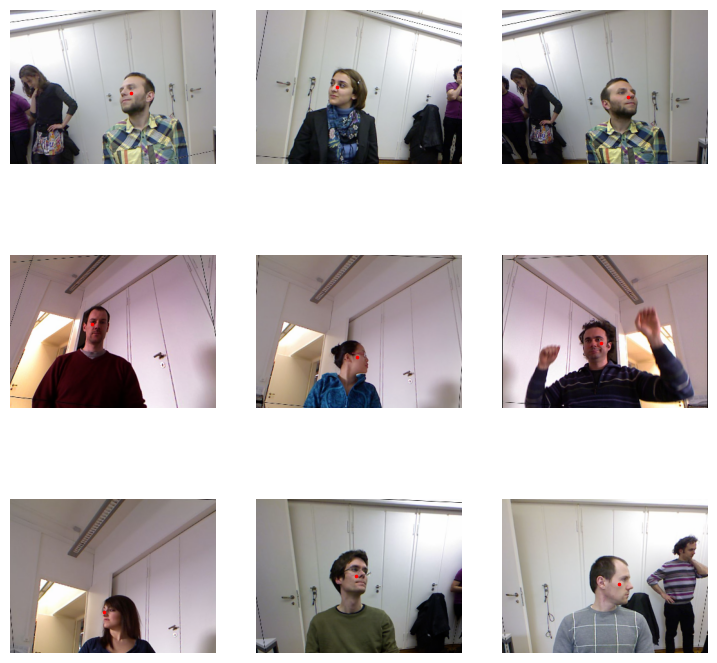

In [12]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9)

In [13]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [14]:
yb[0]

TensorPoint([[0.1280, 0.2712]], device='mps:0')

In [15]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/Users/parhamzam/miniforge3/envs/mlprojects/lib/python3.8/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [16]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0008317637839354575)

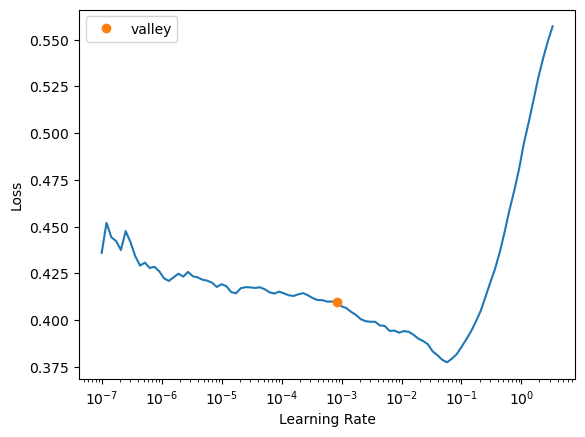

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,0.048404,0.014511,02:12
1,0.007720,0.003872,02:11
2,0.003303,0.001178,02:14
3,0.002453,0.001000,02:12
4,0.001916,0.000479,02:11


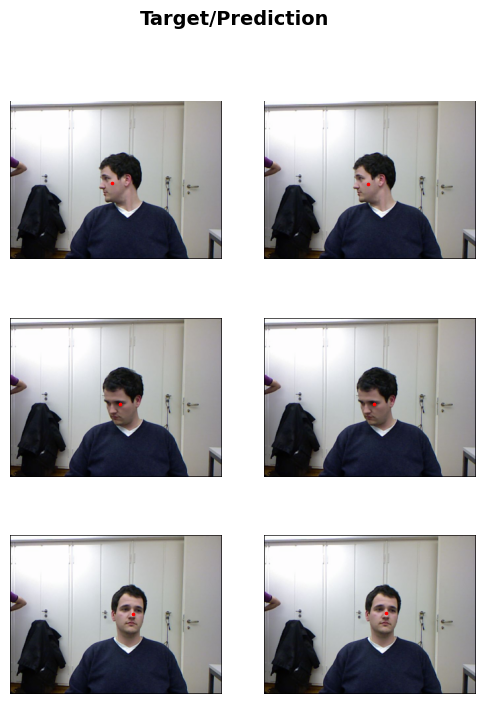

In [39]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))